# Curiosity-driven exploration in VectorIncrement environment

Based on https://pathak22.github.io/noreward-rl/

Setting the right GPU

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

Imports

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tqdm import tqdm

tf.compat.v1.enable_v2_behavior()

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics, py_metrics
from tf_agents.policies import random_tf_policy, epsilon_greedy_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.networks import actor_distribution_network
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.specs import array_spec
from tf_agents.environments import utils, wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.drivers import py_driver

from vectorincrement import *

Environment hyperparameters

In [3]:
v_n = 2
v_k = 2
v_seed = 43
do_transform = True
time_limit = 20

Agent hyperparameters

In [4]:
num_iterations = 500 # @param {type:"integer"}
collect_episodes_per_iteration = 5 # @param {type:"integer"}
replay_buffer_capacity = 1000 # @param {type:"integer"}

fc_layer_params = ()

learning_rate = 1e-3 # @param {type:"number"}
log_interval = 25 # @param {type:"integer"}
num_eval_episodes = 10 # @param {type:"integer"}
eval_interval = 10 # @param {type:"integer"}

Decoder: a linear transformation from observations to features

In [5]:
decoder = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(v_n, input_shape=(v_k,), activation=None,
                             use_bias=False, kernel_initializer='random_normal')
    ]
)

Loading the environment

In [282]:
def get_env():
    """Return a copy of the environment."""
    env = VectorIncrementEnvironmentTFAgents(v_n=v_n, v_k=v_k, v_seed=v_seed,
                                             do_transform=do_transform)
    env = wrappers.TimeLimit(env, time_limit)
    env = tf_py_environment.TFPyEnvironment(env)
    return env

In [283]:
train_env = get_env()
eval_env = get_env()

Defining the agent

In [284]:
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params,
    activation_fn=tf.keras.activations.relu)

In [285]:
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)
tf_agent.initialize()

In [286]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

Standard functions for training

In [6]:
def compute_avg_return(environment, policy, num_episodes=10):
  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [7]:
def collect_episode(environment, policy, num_episodes, replay_buffers):

  episode_counter = 0
  environment.reset()

  while episode_counter < num_episodes:
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    for replay_buffer in replay_buffers:
        replay_buffer.add_batch(traj)

    if traj.is_boundary():
      episode_counter += 1

Training without curiosity

In [289]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [15]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
train_avg_return = compute_avg_return(eval_env, tf_agent.collect_policy, num_eval_episodes)
returns = [avg_return]
train_returns = [train_avg_return]

for _ in range(num_iterations):

  # Collect a few episodes using collect_policy and save to the replay buffer.
  collect_episode(
      train_env, tf_agent.collect_policy, collect_episodes_per_iteration, [replay_buffer])

  # Use data from the buffer and update the agent's network.
  experience = replay_buffer.gather_all()
  train_loss = tf_agent.train(experience)
  replay_buffer.clear()

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    train_avg_return = compute_avg_return(eval_env, tf_agent.collect_policy, num_eval_episodes)
    print('step = {0}: Average Return = {1} Train return = {2}'.format(step, avg_return,
                                                                      train_avg_return))
    returns.append(avg_return)
    train_returns.append(train_avg_return)

step = 10: Average Return = 1.0 Train return = 7.900000095367432
step = 20: Average Return = 2.0 Train return = 7.5
step = 25: loss = -0.2913815379142761
step = 30: Average Return = 3.0 Train return = 8.0
step = 40: Average Return = 3.0 Train return = 7.800000190734863
step = 50: loss = -0.34632986783981323
step = 50: Average Return = 4.0 Train return = 7.599999904632568
step = 60: Average Return = 5.0 Train return = 8.199999809265137
step = 70: Average Return = 5.0 Train return = 8.399999618530273
step = 75: loss = -0.38549041748046875
step = 80: Average Return = 6.0 Train return = 8.300000190734863
step = 90: Average Return = 6.0 Train return = 7.599999904632568
step = 100: loss = -0.5429959297180176
step = 100: Average Return = 7.0 Train return = 9.0
step = 110: Average Return = 6.0 Train return = 8.199999809265137
step = 120: Average Return = 6.0 Train return = 8.0
step = 125: loss = -0.37788811326026917
step = 130: Average Return = 6.0 Train return = 8.5
step = 140: Average Return

Text(0.5, 0, 'Step')

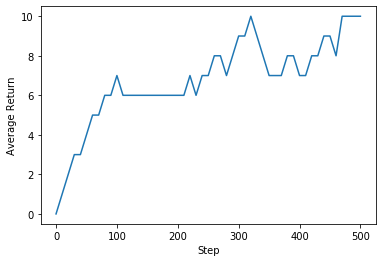

In [17]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')

Curiosity functions

In [290]:
replay_buffer.clear()
collect_episode(train_env, tf_agent.collect_policy, 10, [replay_buffer])

In [8]:
def encode_onehot(x, dim):
    """Encode x as 1-hot of dimension d."""
    assert x in range(dim)
    out = np.zeros(dim)
    out[x] = 1
    return out

def buffer_to_dataset(replay_buffer):
    """Create a dataset from a replay buffer."""
    types = replay_buffer.gather_all().step_type.numpy()[0]
    obs = replay_buffer.gather_all().observation.numpy()[0]
    acts = replay_buffer.gather_all().action.numpy()[0]

    xs = []
    ys = []

    for t, o, a in zip(types, obs, acts):
        oa = np.hstack([o, encode_onehot(a, v_n)])
        if t == 0:
            xs.append(oa)
        elif t == 1:
            xs.append(oa)
            ys.append(o)
        elif t == 2:
            ys.append(o)

    assert len(xs) == len(ys)
    
    return np.array(xs), np.array(ys)

class CuriosityWrapper(wrappers.PyEnvironmentBaseWrapper):
    """Adds a model loss component to the reward."""

    def __init__(self, env, model, alpha=1.0):
        """Initialize.
        
        Args:
            env: tf.agents environment
            model: keras model [observation + one-hot action] -> observation
            alpha: how much l2 norm loss for the model to add to the reward  
        """
        super(CuriosityWrapper, self).__init__(env)

        # saved old time-step
        self.old_step = None

        # keras model taking [obs + one-hot action] and outputting next obs
        self.model = model

        def model_for_obs_and_action(obs, act):
            """Take observation and action as a number, return next observation."""
            z = [np.hstack([obs, encode_onehot(act, v_n)])]
            z = np.array(z)
            return self.model(z)
        self.model_for_obs_and_action = model_for_obs_and_action

        self.last_action = None
        
        self.alpha = alpha

    def transform_step(self, step):
        """Replace a reward inside the step to a curiosity reward (r + model loss)"""
        
        # reward to add
        r = 0

        # resetting old step, if required
        if step.step_type == 0:
            self.old_step = None

        # computing the curiosity reward
        if self.old_step is not None:
            # observation predicted by the model
            pred_obs = self.model_for_obs_and_action(
                self.old_step.observation,
                self.last_action)
            
            # computing the reward as l2 norm for the difference
            r = np.linalg.norm(pred_obs - step.observation, ord=1) / np.linalg.norm(step.observation, ord=1)
            #print(pred_obs, step.observation)
        
        # remembering previous step
        self.old_step = step

        # computing the next reward
        total_reward = step.reward + r

        # returning a step with modified reward
        total_reward = np.asarray(total_reward,
                                  dtype=np.asarray(step.reward).dtype)


        return ts.TimeStep(step.step_type, total_reward, step.discount,
                           step.observation)

    def _reset(self):
        return self.transform_step(self._env.reset())

    def _step(self, action):
        # saving the action for transform_step
        self.last_action = action
        return self.transform_step(self._env.step(action))
    
def m_passthrough_action(decoder):
    """Create a model with last v_n components in input passed through."""
    inputs = tf.keras.Input(shape=(v_k + v_n,))

    decoded_obs = decoder(inputs[:, :v_k])
    passed_action = inputs[:, v_k:]

    merged = tf.keras.layers.Concatenate()([decoded_obs,  passed_action])

    model = tf.keras.Model(inputs=inputs, outputs=merged)
    
    return model

Model of the environment

In [60]:
env_model = tf.keras.Sequential([
   # m_passthrough_action(decoder),
    tf.keras.layers.InputLayer(input_shape=(v_k + v_n,)), # input: [state, one-hot action]
    tf.keras.layers.Dense(v_k) # output: state
])

env_model.compile('adam', 'mse')

Fitting the model on the data from the replay buffer

In [373]:
xs, ys = buffer_to_dataset(replay_buffer)

In [374]:
env_model.evaluate(xs, ys)

200/200 [==============================] - 0s 179us/sample - loss: 0.3537


0.3536817502975464

In [375]:
history = env_model.fit(xs, ys, epochs=500, verbose=0)

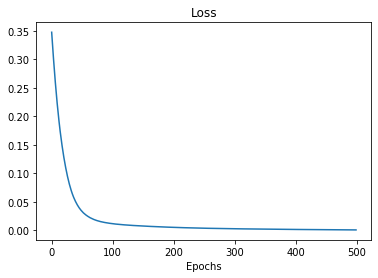

In [376]:
plt.title("Loss")
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.show()

In [377]:
env_model.evaluate(xs, ys)

200/200 [==============================] - 0s 33us/sample - loss: 7.8580e-04


0.0007857955666258931

In [378]:
env_model.weights

[<tf.Variable 'dense_57/kernel:0' shape=(4, 2) dtype=float32, numpy=
 array([[ 0.52985346,  0.0014705 ],
        [ 0.15284945,  0.99951917],
        [-0.41922355, -0.09605799],
        [-0.45698214, -0.04277206]], dtype=float32)>,
 <tf.Variable 'dense_57/bias:0' shape=(2,) dtype=float32, numpy=array([0.410985  , 0.01555174], dtype=float32)>]

Curiosity parameters

In [57]:
alpha = 1.0

curiosity_interval = 20

Creating a curiosity-wrapped environment

In [61]:
decoder = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(v_n, input_shape=(v_k,), activation=None,
                             use_bias=False, kernel_initializer='random_normal')
    ]
)

In [62]:
def get_env(add_curiosity_reward=True):
    """Return a copy of the environment."""
    env = VectorIncrementEnvironmentTFAgents(v_n=v_n, v_k=v_k, v_seed=v_seed,
                                             do_transform=do_transform)
    env = wrappers.TimeLimit(env, time_limit)
    if add_curiosity_reward:
        env = CuriosityWrapper(env, env_model, alpha=1.0)
    env = tf_py_environment.TFPyEnvironment(env)
    return env

In [63]:
train_env = get_env(add_curiosity_reward=True)
eval_env = get_env(add_curiosity_reward=False)

In [64]:
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params,
    activation_fn=tf.keras.activations.relu,
    # for features: add preprocessing_layers=[...]
)

In [65]:
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)
tf_agent.initialize()

In [66]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

In [67]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [68]:
curiosity_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=1000000)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

step = 10: Average Return = 1.0 Train return = 35.21771240234375
step = 20: Average Return = 1.0 Train return = 34.900657653808594


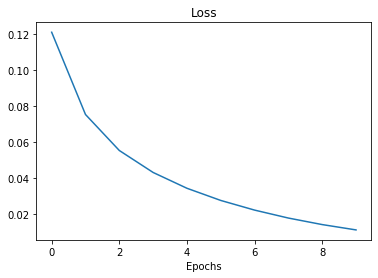

step = 25: loss = -0.5505639910697937
step = 30: Average Return = 2.0 Train return = 15.154927253723145
step = 40: Average Return = 2.0 Train return = 14.856249809265137


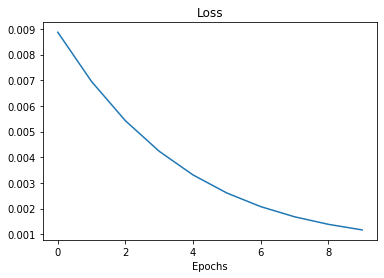

step = 50: loss = -0.4949069917201996
step = 50: Average Return = 3.0 Train return = 9.320261001586914
step = 60: Average Return = 4.0 Train return = 9.981525421142578


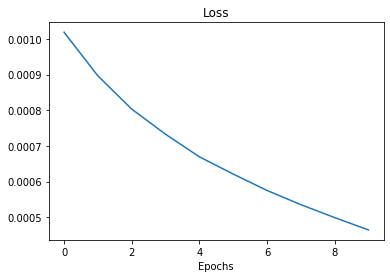

step = 70: Average Return = 4.0 Train return = 9.286162376403809
step = 75: loss = -0.4473296105861664
step = 80: Average Return = 5.0 Train return = 9.02507209777832


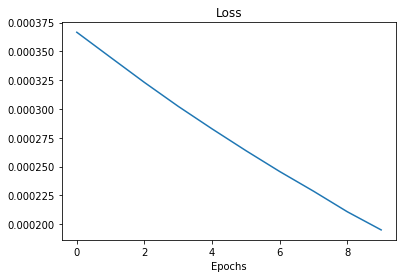

step = 90: Average Return = 5.0 Train return = 8.053199768066406
step = 100: loss = -0.5881438255310059
step = 100: Average Return = 6.0 Train return = 9.499857902526855


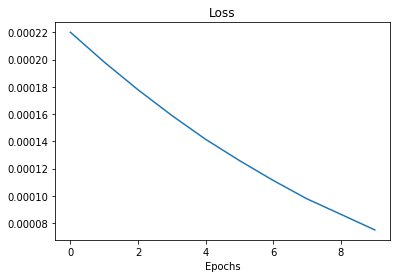

step = 110: Average Return = 6.0 Train return = 8.667398452758789
step = 120: Average Return = 6.0 Train return = 8.275931358337402


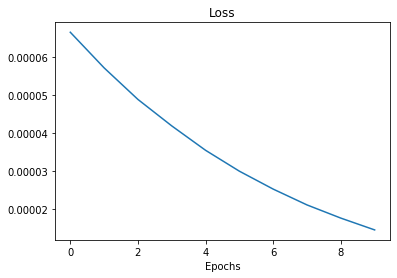

step = 125: loss = -0.39505308866500854
step = 130: Average Return = 6.0 Train return = 8.509489059448242
step = 140: Average Return = 6.0 Train return = 8.915186882019043


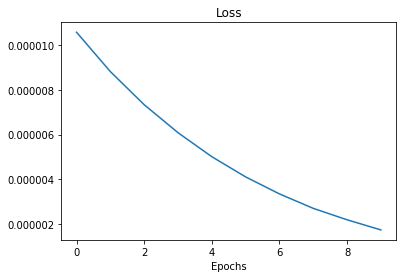

step = 150: loss = -0.33851298689842224
step = 150: Average Return = 6.0 Train return = 8.241052627563477
step = 160: Average Return = 5.0 Train return = 8.041865348815918


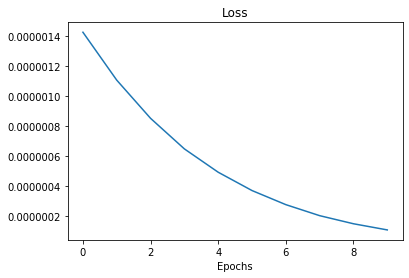

step = 170: Average Return = 5.0 Train return = 7.911334037780762
step = 175: loss = -0.6140324473381042
step = 180: Average Return = 5.0 Train return = 8.110967636108398


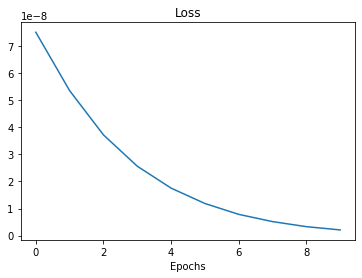

step = 190: Average Return = 6.0 Train return = 8.501112937927246
step = 200: loss = -0.3911074995994568
step = 200: Average Return = 6.0 Train return = 7.701592922210693


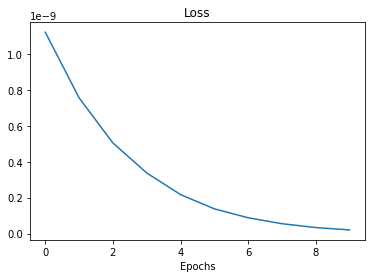

step = 210: Average Return = 6.0 Train return = 8.100176811218262
step = 220: Average Return = 6.0 Train return = 8.300195693969727


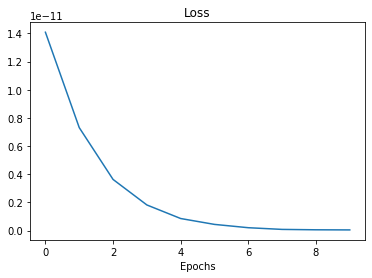

step = 225: loss = -0.3139881491661072
step = 230: Average Return = 6.0 Train return = 8.400007247924805
step = 240: Average Return = 7.0 Train return = 8.500006675720215


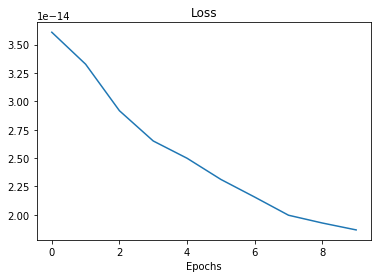

step = 250: loss = -0.5883023142814636
step = 250: Average Return = 7.0 Train return = 7.500002861022949
step = 260: Average Return = 8.0 Train return = 8.600004196166992


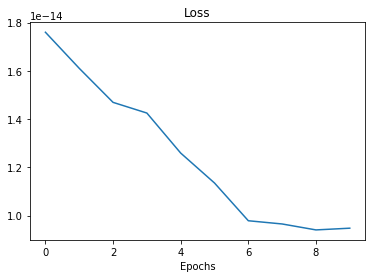

step = 270: Average Return = 8.0 Train return = 8.100001335144043
step = 275: loss = -0.420329749584198
step = 280: Average Return = 7.0 Train return = 8.50000286102295


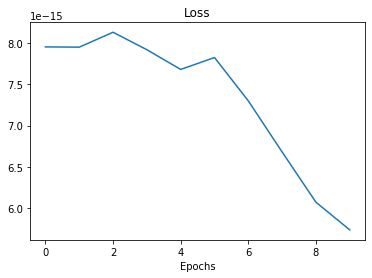

step = 290: Average Return = 8.0 Train return = 8.300002098083496
step = 300: loss = -0.3836154341697693
step = 300: Average Return = 9.0 Train return = 8.60000228881836


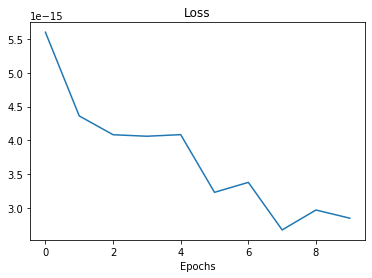

step = 310: Average Return = 9.0 Train return = 8.500000953674316
step = 320: Average Return = 10.0 Train return = 7.100001335144043


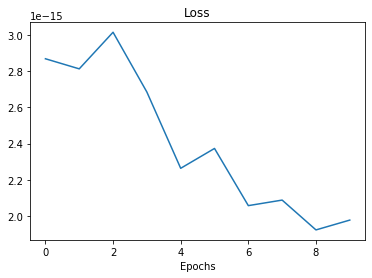

step = 325: loss = -0.5419471859931946
step = 330: Average Return = 9.0 Train return = 7.800001621246338
step = 340: Average Return = 8.0 Train return = 8.600000381469727


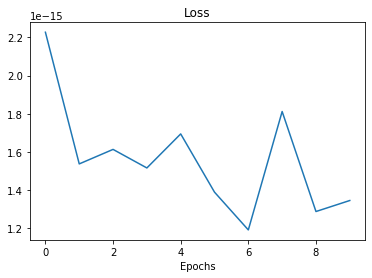

step = 350: loss = -0.32930269837379456
step = 350: Average Return = 7.0 Train return = 8.699999809265137
step = 360: Average Return = 7.0 Train return = 7.40000057220459


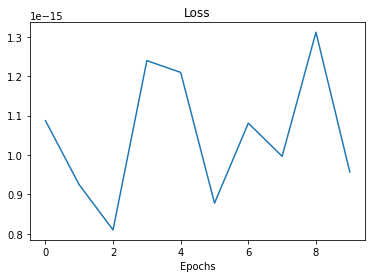

step = 370: Average Return = 7.0 Train return = 8.200000762939453
step = 375: loss = -0.367305189371109
step = 380: Average Return = 8.0 Train return = 8.30000114440918


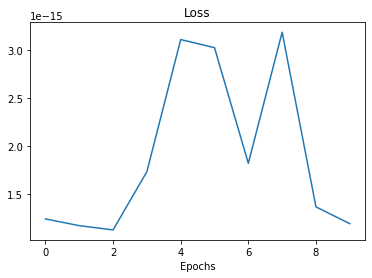

step = 390: Average Return = 8.0 Train return = 7.90000057220459
step = 400: loss = -0.43747758865356445
step = 400: Average Return = 7.0 Train return = 8.20000171661377


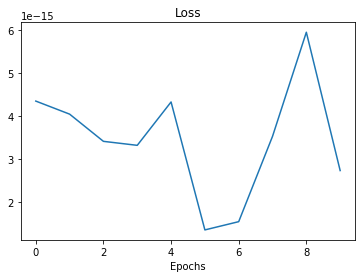

step = 410: Average Return = 7.0 Train return = 8.0
step = 420: Average Return = 8.0 Train return = 7.699999809265137


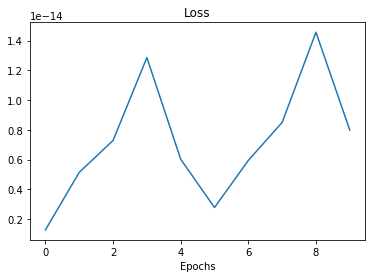

step = 425: loss = -0.5696204900741577
step = 430: Average Return = 8.0 Train return = 8.400003433227539
step = 440: Average Return = 9.0 Train return = 8.100003242492676


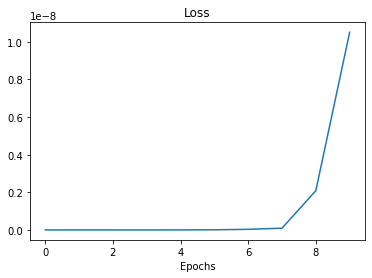

step = 450: loss = -0.3930034637451172
step = 450: Average Return = 9.0 Train return = 7.402008056640625
step = 460: Average Return = 8.0 Train return = 8.002042770385742


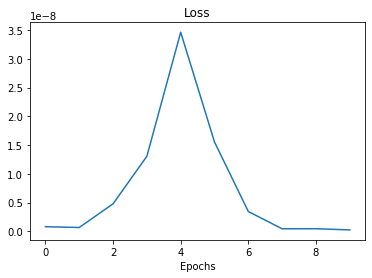

step = 470: Average Return = 10.0 Train return = 8.700674057006836
step = 475: loss = -0.36081379652023315
step = 480: Average Return = 10.0 Train return = 8.200567245483398


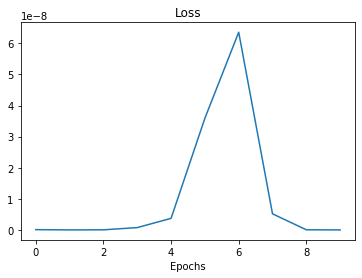

step = 490: Average Return = 10.0 Train return = 8.500014305114746
step = 500: loss = -0.5136817693710327
step = 500: Average Return = 10.0 Train return = 8.200014114379883


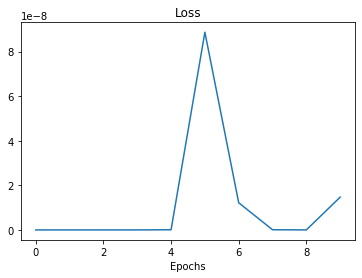

In [69]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
train_avg_return = compute_avg_return(eval_env, tf_agent.collect_policy, num_eval_episodes)
returns = [avg_return]
train_returns = [train_avg_return]
curiosity_loss = []

for _ in range(num_iterations):

  # Collect a few episodes using collect_policy and save to the replay buffer.
  collect_episode(train_env, tf_agent.collect_policy,
                  collect_episodes_per_iteration,
                  [replay_buffer,curiosity_replay_buffer])

  # Use data from the buffer and update the agent's network.
  experience = replay_buffer.gather_all()
  train_loss = tf_agent.train(experience)
  replay_buffer.clear()

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    train_avg_return = compute_avg_return(train_env, tf_agent.collect_policy, num_eval_episodes)
    print('step = {0}: Average Return = {1} Train return = {2}'.format(step, avg_return,
                                                                      train_avg_return))
    returns.append(avg_return)
    train_returns.append(train_avg_return)
    
  if step % curiosity_interval == 0:
    xs, ys = buffer_to_dataset(curiosity_replay_buffer)
    history = env_model.fit(xs, ys, epochs=10, verbose=0)
    plt.title("Loss")
    plt.plot(history.history['loss'])
    curiosity_loss += list(history.history['loss'])
    plt.xlabel("Epochs")
    plt.show()
    curiosity_replay_buffer.clear()

Text(0.5, 0, 'Step')

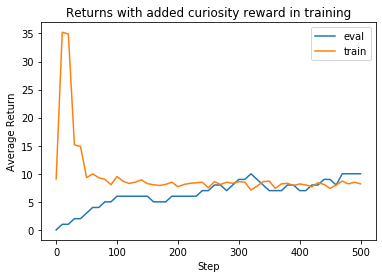

In [76]:
steps = range(0, num_iterations + 1, eval_interval)
plt.title("Returns with added curiosity reward in training")
plt.plot(steps, returns, label="eval")
plt.plot(steps, train_returns, label="train")
plt.ylabel('Average Return')
plt.legend()
plt.xlabel('Step')

Evaluating the model

In [74]:
curiosity_replay_buffer.clear()
collect_episode(eval_env, tf_agent.collect_policy, 25, [curiosity_replay_buffer])
collect_episode(eval_env, tf_agent.policy, 25, [curiosity_replay_buffer])
xs, ys = buffer_to_dataset(curiosity_replay_buffer)
env_model.evaluate(xs, ys)

1000/1000 [==============================] - 0s 45us/sample - loss: 1.2005e-08


1.2005000626924556e-08

In [73]:
xs

array([], dtype=float64)